In [1]:
import numpy as np
import EI_subspace_RNN
import scipy.stats as stats
import scipy.linalg
from utils import *
from plotting_utils import *
import matplotlib.pyplot as plt
colormap = ['tab:purple','tab:pink','tab:cyan','yellowgreen', 'olive']

# hyperparameters
N_e = 30
N_i = 30
N = N_e + N_i 
K = 3 
J = np.random.normal(0, 1/np.sqrt(N), (N,N))
J, _ = np.linalg.qr(J)  # QR decomposition, Q is the orthogonal matrix
J = J[:K,:]
J_inv = np.linalg.pinv(J) # pseudo-inverse (J * J_inv = identity, but J_inv * J is not)
sparsity = 0.25
D = 10
U = 50
T = 100
N_weights = int (N * N * sparsity)
print(J.shape)
print(N_weights)


(3, 60)
900


[[-0.17771988  0.32109866 -1.36126543]
 [-0.93369154 -0.91639729  1.02235723]
 [ 1.62491779  0.61782626  1.79411716]]


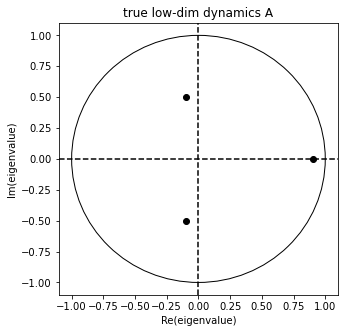

In [2]:
eigenvalues = np.array([0.9, - 0.1 + 0.5j, - 0.1 - 0.5j])
trueA = generate_dynamics_A(eigenvalues) # checked that A has above eigenvalues
trueA = np.load('trueA.npy')
print(trueA)
fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('true low-dim dynamics A')
plot_eigenvalues(axes, eigenvalues)


In [3]:
# # Weight initialization (step 0) - Hannequin et al 2012
# RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
# w0 = RNN.generate_stable_weights(R=0.85) 
# W0 = RNN.build_full_weight_matrix(w0)

# eig = np.linalg.eigvals(W0) 
# fig, axes = plt.subplots(figsize=(5,5))
# axes.set_title('W initialization (step 0)')
# plot_eigenvalues(axes, eig)


In [4]:
# from scipy.optimize import minimize, Bounds
# max_iter = 10
# def generate_or_initialize_weights_from_dynamics_LDS111(self, A_target, R=0.85, alpha_beta_list = [10 ** i for i in list(np.arange(-3,0.5,0.25))]):

#         # ADD TOLERANCE TO STOP WHEN ITERATING

#         # step 1 like in Hannequin et al 2012
#     w = self.generate_stable_weights(R=R) 
#     W = self.build_full_weight_matrix(w0)

#     max_iter = 10

#     w_all = np.zeros((max_iter, self.N_weights))
#     loss_W = np.zeros((max_iter*2, 3))

#     JpJ = np.linalg.pinv(self.J) @ self.J
#     w_old = np.copy(w)
#     for iter in range(max_iter):
#         # to satisfy low-dim dynamics constraint
#         W = JpJ @ W @ JpJ + (np.eye(self.N) - JpJ) @ W @ (np.eye(self.N) - JpJ)

#         # to satisfy E-I balance 
#         W = W - W @ np.ones((self.N,1)) @ np.ones((1, self.N)) / self.N

#         # to keep only active weights & Dale's law
#         w = np.abs(self.get_nonzero_weight_vector(W))
#         W = self.build_full_weight_matrix(w)

#         eig = np.linalg.eigvals(W) 
#         fig, axes = plt.subplots(figsize=(5,5))
#         axes.set_title('W initialization (step 2)')
#         plot_eigenvalues(axes, eig)

#         loss_W[iter*2, :] = self.check_loss_weights_LDS(w.flatten(), A_target)

#             # print(np.linalg.norm(J @ W0 @ (np.eye(N)-JpJ))) # checked
#             # print(np.linalg.norm(W0 @ np.ones((N,1))))
        
#         opt_fun = lambda w_flattened: self.loss_weights_target_LDS(w_flattened, A_target, alpha=0.01, beta=0.001)
#         opt_grad = lambda w_flattened: self.gradient_weights_target_LDS(w_flattened, A_target, alpha=0.1, beta=0.001)
#         bounds = [(0, np.inf)] * w0.shape[0]
#         w = minimize(opt_fun, w_old.flatten(), jac=opt_grad, method='L-BFGS-B', bounds=bounds).x  
#         w_old = np.copy(w)
#         w_all[iter, :] = np.copy(w)

#         W = self.build_full_weight_matrix(w)
#         eig = np.linalg.eigvals(W) 
#         fig, axes = plt.subplots(figsize=(5,5))
#         axes.set_title('W initialization (step 2)')
#         plot_eigenvalues(axes, eig)

#         loss_W[iter*2+1, :] = self.check_loss_weights_LDS(w.flatten(), A_target)
    
#     # loss_W[ind, :] = self.check_loss_weights_LDS(w_old.flatten(), A_target)
        
#     # w_all = np.zeros((len(alpha_beta_list), self.N_weights))
#     # loss_W = np.zeros((len(alpha_beta_list)+1, 3))
#     # w_old =  np.copy(w0)
#     # # step 2 (target LDS dynamics matrix - either true one or fit)
#     # for ind in range(len(alpha_beta_list)):
#     #     alpha = 10 * alpha_beta_list[ind]
#     #     print(alpha)
#     #     beta = alpha_beta_list[ind]
#     #     loss_W[ind, :] = self.check_loss_weights_LDS(w_old.flatten(), A_target)
#     #     opt_fun = lambda w_flattened: self.loss_weights_target_LDS(w_flattened, A_target, alpha, beta)
#     #     opt_grad = lambda w_flattened: self.gradient_weights_target_LDS(w_flattened, A_target, alpha, beta)
#     #     bounds = [(0, np.inf)] * w0.shape[0]
#     #     w = minimize(opt_fun, w_old.flatten(), jac=opt_grad, method='L-BFGS-B', bounds=bounds).x  
#     #     w_old = np.copy(w)
#     #     w_all[ind, :] = np.copy(w)
    
#     # loss_W[-1, :] = self.check_loss_weights_LDS(w.flatten(), A_target)
#     W = self.build_full_weight_matrix(w)

#     return W0, W, loss_W, w_all

# # Weight initialization - from true target LDS A
# alpha_beta_list = [0,0] #[10 ** i for i in list(np.arange(-3,1,0.5))]
# # alpha_beta_list = [10 ** i for i in list(np.arange(2,-2.5,-0.5))]
# initW0, initW, loss_W, w_all = generate_or_initialize_weights_from_dynamics_LDS111(RNN, A_target=trueA, R=0.85, alpha_beta_list = alpha_beta_list)
# init_w = RNN.get_nonzero_weight_vector(initW)
# initA = build_dynamics_matrix_A(initW, J)
# # np.save('loss_W', loss_W)
# # np.save('init_w', init_w)

# fig, axes = plt.subplots(figsize=(8,5))
# axes.plot(range(max_iter*2), loss_W[:,0], color='black', label='matching LDS A')
# axes.scatter(range(max_iter*2), loss_W[:,0], color='black')
# axes.plot(range(max_iter*2), loss_W[:,1], color='tab:blue', label='self-containment')
# axes.scatter(range(max_iter*2), loss_W[:,1], color='tab:blue')
# axes.plot(range(max_iter*2), loss_W[:,2], color='tab:green', label='EI balance')
# axes.scatter(range(max_iter*2), loss_W[:,2], color='tab:green')
# axes.legend()
# axes.set_title('initialization procedure for weights')
# axes.set_ylabel('loss term for weights')
# axes.set_xlabel('iteration')


In [5]:
# w0 = RNN.generate_stable_weights(R=0.85) 
# W0 = RNN.build_full_weight_matrix(w0)

# # W0 = J_inv @ trueA @ J

# JpJ = np.linalg.pinv(RNN.J) @ RNN.J
# for iter in range(10):
#     # to satisfy low-dim dynamics constraint
#     # W0 = JpJ @ W0 @ JpJ + (np.eye(RNN.N) - JpJ) @ W0 @ (np.eye(RNN.N) - JpJ) #- J_inv @ trueA @ J
#     W0 = J_inv @ (J @ W0 @ J_inv - trueA / N) @ J + (np.eye(RNN.N) - JpJ) @ W0 @ (np.eye(RNN.N) - JpJ)

#     # to satisfy E-I balance 
#     W0 = W0 - W0 @ np.ones((RNN.N,1)) @ np.ones((1, RNN.N)) / RNN.N

#     # to keep only active weights & Dale's law
#     w0 = np.abs(RNN.get_nonzero_weight_vector(W0))
#     W0 = RNN.build_full_weight_matrix(w0)

#             # print(np.linalg.norm(J @ W0 @ (np.eye(N)-JpJ))) # checked
#             # print(np.linalg.norm(W0 @ np.ones((N,1))))
    
# eig = np.linalg.eigvals(W0) 
# fig, axes = plt.subplots(figsize=(5,5))
# axes.set_title('W initialization (step 1)')
# plot_eigenvalues(axes, eig)

# fig, axes = plt.subplots(figsize=(5,5))
# eig = np.linalg.eigvals(trueA) 
# plot_eigenvalues(axes, eig, color='black', label='true A')
# eig = np.linalg.eigvals(J @ W0 @ J_inv) 
# plot_eigenvalues(axes, eig, color='tab:red', label='init A from weights')
# axes.legend()
# plt.show()

0
1e-05
1
1
1
3.1622776601683795e-05
1
1
2
0.0001
1
1
3
0.00031622776601683794
1
1
4
0.001
1
1
5
0.0031622776601683794
1
1
6
0.01
1
1
7
0.03162277660168379
1
1
8
0.1
1
1
9
0.31622776601683794
1
1
10
1.0
1
1


Text(0.5, 0, 'iteration')

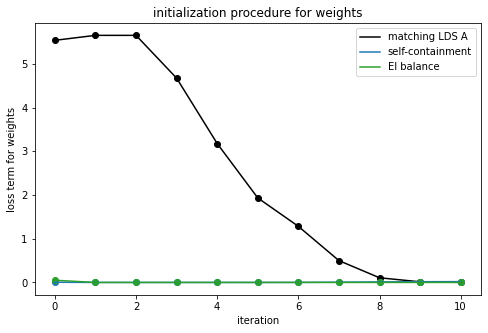

In [14]:
# Weight initialization - from true target LDS A
RNN = EI_subspace_RNN.EI_subspace_RNN(N_e, N_i, sparsity, J, seed=1)
zeta_alpha_beta_list = [(10**i,1,1) for i in list(np.arange(-5,0.5,0.5))] #[10 ** i for i in list(np.arange(-3,1,0.5))]
# alpha_beta_list = [10 ** i for i in list(np.arange(2,-2.5,-0.5))]
initW0, initW, loss_W, w_all = RNN.generate_or_initialize_weights_from_dynamics_LDS(A_target=trueA, R=0.85, zeta_alpha_beta_list = zeta_alpha_beta_list)
init_w = RNN.get_nonzero_weight_vector(initW)
initA = build_dynamics_matrix_A(initW, J)
# np.save('loss_W', loss_W)
# np.save('init_w', init_w)

fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(len(zeta_alpha_beta_list)), loss_W[:,0], color='black', label='matching LDS A')
axes.scatter(range(len(zeta_alpha_beta_list)), loss_W[:,0], color='black')
axes.plot(range(len(zeta_alpha_beta_list)), loss_W[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(len(zeta_alpha_beta_list)), loss_W[:,1], color='tab:blue')
axes.plot(range(len(zeta_alpha_beta_list)), loss_W[:,2], color='tab:green', label='EI balance')
axes.scatter(range(len(zeta_alpha_beta_list)), loss_W[:,2], color='tab:green')
axes.legend()
axes.set_title('initialization procedure for weights')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')


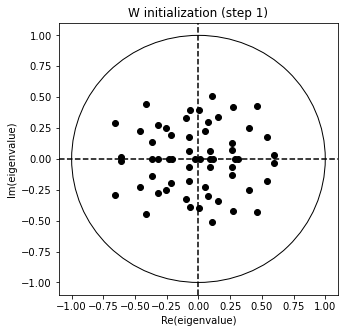

In [15]:
eig = np.linalg.eigvals(initW0) 
# eig = np.linalg.eigvals(J @ W0 @ J_inv) 
fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('W initialization (step 1)')
plot_eigenvalues(axes, eig)

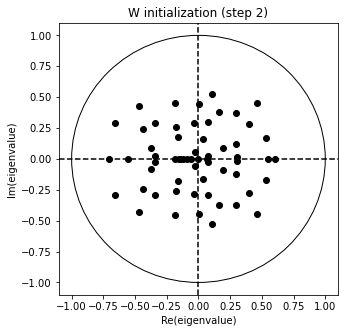

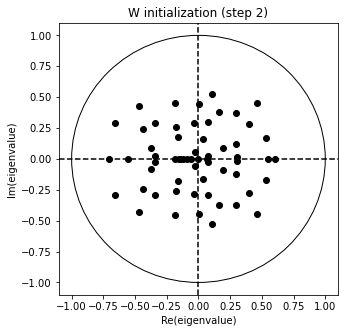

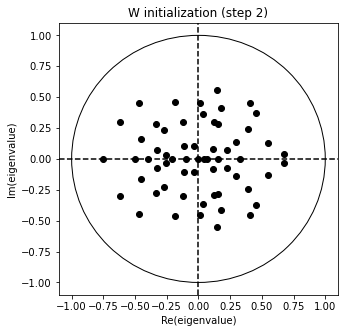

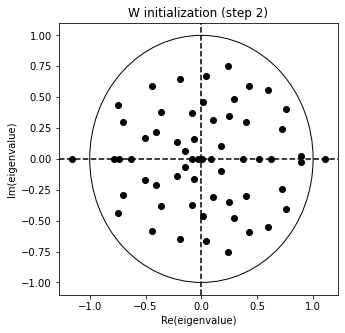

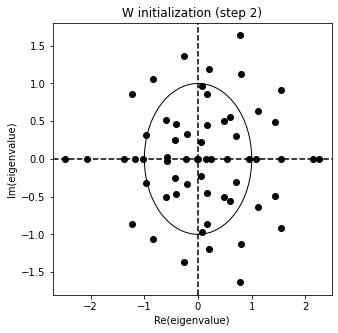

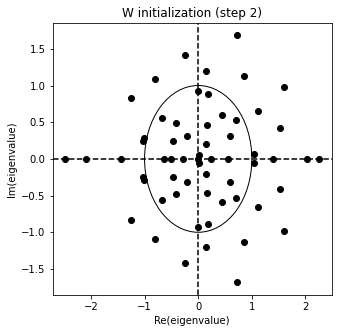

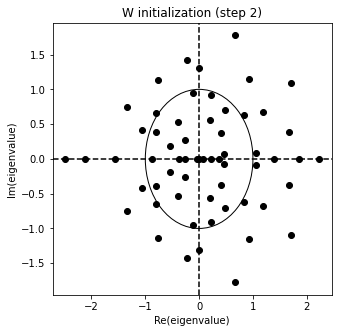

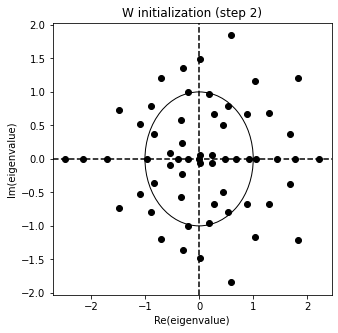

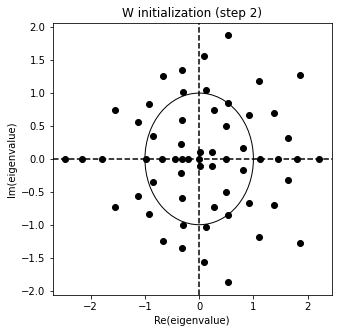

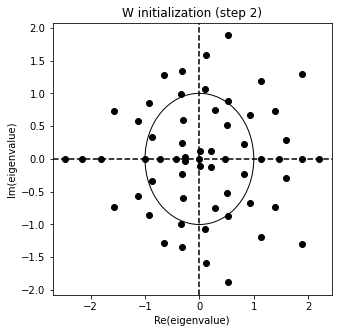

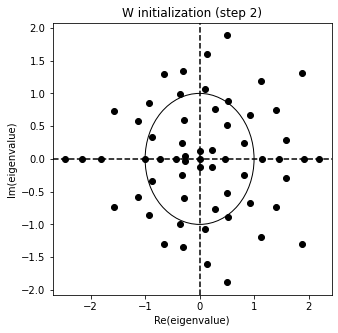

In [16]:
for ind in range(len(zeta_alpha_beta_list)):
    Winit = RNN.build_full_weight_matrix(w_all[ind])
    eig = np.linalg.eigvals(Winit) 
    fig, axes = plt.subplots(figsize=(5,5))
    axes.set_title('W initialization (step 2)')
    plot_eigenvalues(axes, eig)

In [21]:
Jpinv_aux = J @ initW @ (np.identity((N)) - np.linalg.pinv(J) @ J)
print(0.5  * np.trace(Jpinv_aux @ Jpinv_aux.T))

0.032754171939245916


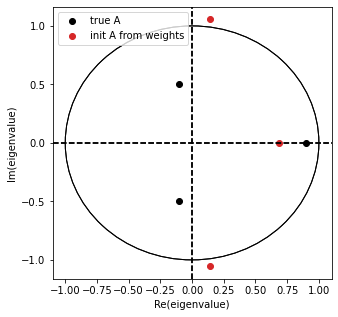

In [22]:
fig, axes = plt.subplots(figsize=(5,5))
eig = np.linalg.eigvals(trueA) 
plot_eigenvalues(axes, eig, color='black', label='true A')
eig = np.linalg.eigvals(initA) 
plot_eigenvalues(axes, eig, color='tab:red', label='init A from weights')
axes.legend()
plt.show()

In [23]:
true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R = RNN.generate_parameters(D, K)
x, y = RNN.generate_latents_and_observations(U, T, trueA, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R)
print(x.shape)
print(y.shape)

(50, 100, 3, 1)
(50, 100, 10, 1)


In [24]:
w0_Lea = RNN.get_nonzero_weight_vector(initW0)
# print(np.linalg.norm(J @ initW0 @ (np.eye(N) - JpJ))) # constraint for self-containment

In [28]:
max_iter = 20
# loss_W, w, b, s, mu0, Q0, C_, d, R = RNN.fit_EM(y, init_w, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R, alpha=10, beta=10, max_iter=max_iter)
loss_W, w, b, s, mu0, Q0, C_, d, R = RNN.fit_EM(y, w0_Lea, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R, alpha=10, beta=1, max_iter=max_iter)


0
10


In [161]:
# PLOT THE FREE ENERGY TO CHECK IT GOES UP AFTER EVERY EM STEP

# CHECK WEIGHTS RECOVER WELL

# CHECK ALL OTHER PARAMS RECOVER WELL TOGETHER

# UNDERSTAND & FIX OVERFLOW IN NETWORK ACTIVITY

Text(0.5, 0, 'iteration')

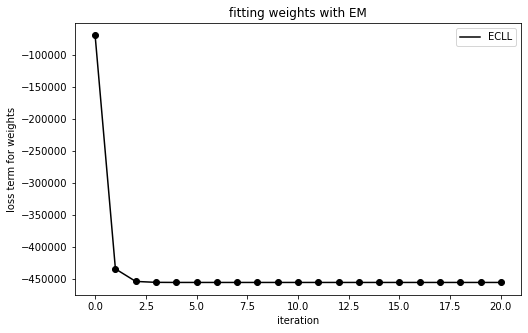

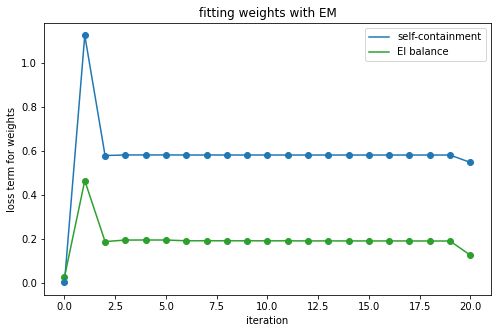

In [29]:
fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(max_iter+1), loss_W[:,0], color='black', label='ECLL')
axes.scatter(range(max_iter+1), loss_W[:,0], color='black')
axes.legend()
axes.set_title('fitting weights with EM')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')

fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(max_iter+1), loss_W[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(max_iter+1), loss_W[:,1], color='tab:blue')
axes.plot(range(max_iter+1), loss_W[:,2], color='tab:green', label='EI balance')
axes.scatter(range(max_iter+1), loss_W[:,2], color='tab:green')
axes.legend()
axes.set_title('fitting weights with EM')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')


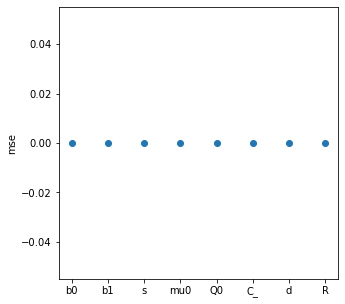

In [85]:
fig, axes = plt.subplots(figsize=(5,5))
plot_mse_parameters(axes, b, s, mu0, Q0, C_, d, R, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R)
plt.show()

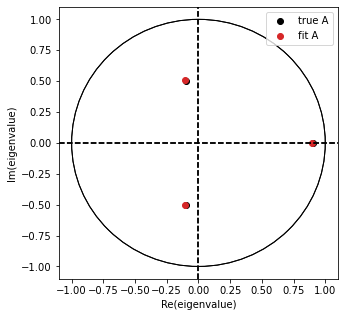

In [86]:
# recovered eigenspectrum from weights
fig, axes = plt.subplots(figsize=(5,5))
W = RNN.build_full_weight_matrix(w)
fitA = build_dynamics_matrix_A(W, J)
plot_eigenvalues(axes, np.linalg.eigvals(trueA), color='black', label='true A')
plot_eigenvalues(axes, np.linalg.eigvals(fitA), color='tab:red', label='fit A')
axes.legend()
plt.show()


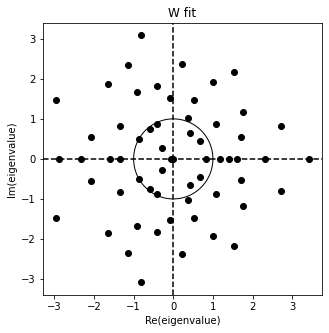

In [87]:
eig = np.linalg.eigvals(W) 
fig, axes = plt.subplots(figsize=(5,5))
axes.set_title('W fit')
plot_eigenvalues(axes, eig)

In [88]:
# generate network activity from fit W
v = RNN.generate_network_activity(U, T, W, b, s, mu0, Q0)
print(v.shape)

(50, 100, 60, 1)


(50, 60, 1)


Text(0, 0.5, 'network activity')

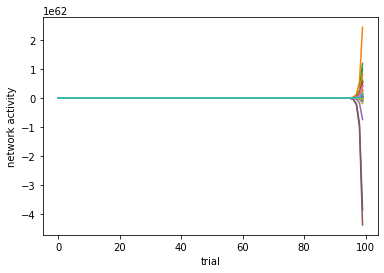

In [36]:
fig, axes = plt.subplots()
for i in range(50):
    axes.plot(v[0,:,i])
axes.set_xlabel('trial')
axes.set_ylabel('network activity')

# SLOW INCREASE OF ALPHA AND BETA DURING FITTING


In [67]:
max_iter = 4
alpha_beta_list = [10 ** i for i in list(np.arange(-1.5,6.5,0.25))]
loss_W = np.zeros(((len(alpha_beta_list) + 1) * (max_iter + 1), 3))
w = np.zeros((len(alpha_beta_list) + 1, N_weights))
loss_W[:max_iter+1,:], w[0,:], b, s, mu0, Q0, C_, d, R = RNN.fit_EM(y, init_w, true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R, alpha=0, beta=0, max_iter=max_iter)
c = 1
for alpha in alpha_beta_list:
    loss_W[(max_iter+1)*c : (max_iter+1)*(c+1),:], w[c,:], b, s, mu0, Q0, C_, d, R = RNN.fit_EM(y, w[c-1,:], true_b, true_s, true_mu0, true_Q0, true_C_, true_d, true_R, alpha=alpha*10, beta=alpha, max_iter=max_iter)
    c+= 1

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


Text(0.5, 0, 'iteration')

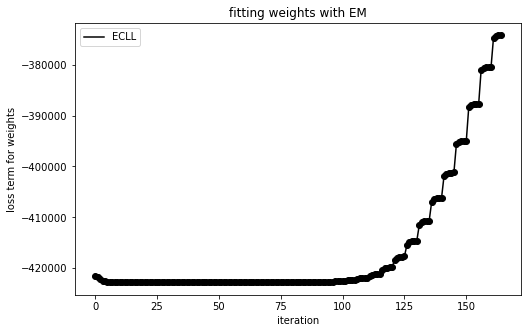

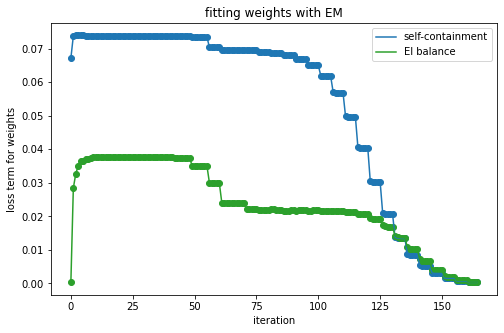

In [68]:
fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(loss_W.shape[0]), loss_W[:,0], color='black', label='ECLL')
axes.scatter(range(loss_W.shape[0]), loss_W[:,0], color='black')
axes.legend()
axes.set_title('fitting weights with EM')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')

fig, axes = plt.subplots(figsize=(8,5))
axes.plot(range(loss_W.shape[0]), loss_W[:,1], color='tab:blue', label='self-containment')
axes.scatter(range(loss_W.shape[0]), loss_W[:,1], color='tab:blue')
axes.plot(range(loss_W.shape[0]), loss_W[:,2], color='tab:green', label='EI balance')
axes.scatter(range(loss_W.shape[0]), loss_W[:,2], color='tab:green')
axes.legend()
axes.set_title('fitting weights with EM')
axes.set_ylabel('loss term for weights')
axes.set_xlabel('iteration')

Text(0, 0.5, 'network activity')

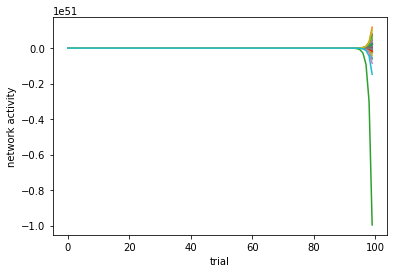

In [73]:
# for c in range(0,len(alpha_beta_list)+1):
#     W = RNN.build_full_weight_matrix(w[c])
#     eig = np.linalg.eigvals(W) 
#     fig, axes = plt.subplots(figsize=(5,5))
#     axes.set_title('W fit')
#     plot_eigenvalues(axes, eig)

c = -1 
W = RNN.build_full_weight_matrix(w[c])
# generate network activity from fit W
v = RNN.generate_network_activity(U, T, W, b, s, mu0, Q0)
fig, axes = plt.subplots()
for i in range(50):
    axes.plot(v[0,:,i])
axes.set_xlabel('trial')
axes.set_ylabel('network activity')